In [370]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import scipy.io as io
from MyML import *

In [2]:
def res(X,mu, sigma, Pi):
#     print(X.shape)
#     print(mu.shape)
#     print(sigma.shape)
#     print(Pi)
    d = Pi*sp.multivariate_normal.pdf(X, mu, sigma)
    return d

In [3]:
full = io.loadmat('shuttle.mat')

In [183]:
def TVTsplit(matrix, train = .7):
    #     This function's purpose is to split a given matrix
    #     into three parts: train, test, and validate. The 
    #     train parameter is the percentage of the data that
    #     goes into training 70% by default. The val parameter
    #     determines how much goes into the validation set
    #     15% by default. The rest of the data goes into
    #     the test set.
    
#     The following is needed to perform the operations
#     in the calculations in here.
    import numpy as np
    # The following does some common sense things like
    # telling you that train and val need to add up to less
    # than 1.

    if(train > .99):
        print("Splitting failed. Please make sure that train is less than .99 so that test and val have enough data.")
        return 0
    
#     These two things calculate the subset lengths that 
#     are needed for the subsetting.
    splitnum = int(len(matrix[:,0])*train)
    splitnum2 = int((len(matrix[:,0]) - splitnum)/2)
#     np.random.shuffle(matrix)

#     The next three separate the data into the three sets
#     using the splitnums from above.
    Train = matrix[0:splitnum,]
    Test = matrix[splitnum:(splitnum+splitnum2),]
    Val = matrix[(splitnum+splitnum2):,]
    return Train, Val, Test

In [184]:
fullX = np.array(full['X'], dtype = float)
fullY = full['y']

In [186]:
train,val, test = TVTsplit(np.column_stack((fullX,fullY)))

In [187]:
Xtrain = train[np.where(train[:,-1] == 0)[0],:-1]

In [188]:
len(fullX)

49097

In [270]:
k = 14
M = np.empty((k,Xtrain.shape[1]))
sigma = np.empty((Xtrain.shape[1],Xtrain.shape[1],k))
M = Xtrain[np.random.choice(Xtrain.shape[0],k)].astype(np.float64)
for i in range(k):
    r = np.random.randn(9,9)*500
    sigma[:,:,i] = r.T@r
Pi = np.ones(k)/k
for i in range(40):
    print(i)
    D = np.empty((len(Xtrain),k))
    for i in range(0,k):
        D[:,i] = np.array(res(Xtrain, M[i,], sigma[:,:,i], Pi[i]), dtype = float)
    D = D/np.sum(D, axis = 1).reshape(-1,1)
    Pi = np.mean(D,axis = 0)
    for i in range(0,k):
        M[i,] = np.array(np.sum(D[:,i].reshape(-1,1)*Xtrain, axis = 0)/np.sum(D[:,i]).reshape(-1,1), dtype = float)
        sigma[:,:,i] = (D[:,i].reshape(-1,1)*(Xtrain - M[i,])).T@(Xtrain - M[i,])/np.sum(D[:,i]).reshape(-1,1) + .00001*np.eye(fullX.shape[1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [271]:
newD = np.empty((len(train[:,:-1]),k))
for i in range(0,k):
    newD[:,i] = np.array(res(train[:,:-1], M[i,], sigma[:,:,i], Pi[i]), dtype = float)

In [277]:
len(train[:,-1])-np.sum((np.sum(newD, axis = 1)<3e-18).reshape(-1,1) == train[:,-1].reshape(-1,1))

69

In [486]:
newestD = np.empty((len(test[:,:-1]),k))
for i in range(0,k):
    newestD[:,i] = np.array(res(test[:,:-1], M[i,], sigma[:,:,i], Pi[i]), dtype = float)

In [487]:
len(test[:,-1])-np.sum((np.sum(newestD, axis = 1)<1e-17).reshape(-1,1) == test[:,-1].reshape(-1,1))

36

# Start KNN

In [180]:
def dist(a,b):
    return np.sum((a-b)**2, axis  = 1)

In [509]:
Xtrain = (train[:,:-1] - trainmin)/(trainmax - trainmin)
Xval = (val[:,:-1] - trainmin)/(trainmax - trainmin)

In [511]:
Dknn = np.empty((len(Xval),len(Xtrain)))
for i in range(len(Xval)):
    Dknn[i,] = dist(Xtrain,Xval[i,])
prednum = np.argsort(Dknn, axis = 1)[:,0:1]

In [512]:
Ytrain = train[:,-1]
yknnvotes = Ytrain[prednum]
predYknn = yknnvotes

In [513]:
predYknn = []
for i in range(len(yknnvotes)):
    uniques, counts = np.unique(yknnvotes[i], return_counts = True)
    newcounts = counts[np.argsort(counts)]
    newercounts = (newcounts == np.max(newcounts))
    num = np.sum(newercounts).astype(int)
    index = np.random.randint(0,num)
    predYknn.append(uniques[np.argsort(counts)[-num]])

In [515]:
len(val) - np.sum(predYknn == val[:,-1])

5

# Start KNN-dist

In [525]:
newdist = []
for i in range(len(Dknn)):
    subD = Dknn[i,np.argsort(Dknn[i,])[0:9]]
    newdist.append(np.sum(subD))


In [544]:
predYdist = np.array(newdist) > .1
np.sum(predYdist != val[:,-1])

509

In [517]:
newDval = np.empty((len(val[:,:-1]),k))
for i in range(0,k):
    newDval[:,i] = np.array(res(Xval, M[i,], sigma[:,:,i], Pi[i]), dtype = float)

In [523]:
predYgmm = (np.sum(newDval, axis = 1)<3e-18).astype(int)

514

In [519]:
predYdist = np.array(predYdist).astype(int)

In [412]:
import gc
gc.collect()

81

In [444]:
trainmax = np.max(train[:,:-1], axis = 0)
trainmin = np.min(train[:,:-1], axis = 0)

In [469]:
annmodel = NeuralNetwork(indims = 9, nodes = [20,20,20,20,1], activations = ['relu','relu','relu','relu'], taskType = 'c')

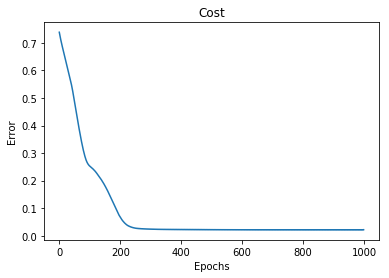

In [470]:
annmodel.train((train[:,:-1]-trainmin)/(trainmax - trainmin),train[:,-1].reshape(-1,1),(val[:,:-1]-trainmin)/(trainmax - trainmin),val[:,-1].reshape(-1,1), optim = 'adam', lr = .001, epochs = 1000)

In [471]:
np.sum(annmodel.prediction != val[:,-1].reshape(-1,1))

24

In [472]:
Votes = np.column_stack((predYdist,predYgmm,predYknn,annmodel.prediction))

In [476]:
ensemble = NeuralNetwork(indims = 4, nodes = [10,10,10,1], activations = ['relu','relu','relu'], taskType = 'c')

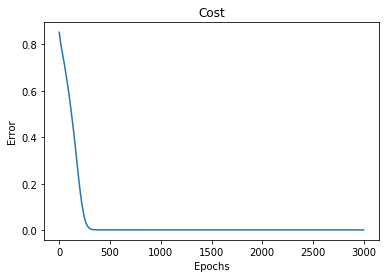

In [477]:
ensemble.train(Votes,val[:,-1].reshape(-1,1), optim = 'adam', lr = .001, epochs = 3000)

In [495]:
valpreds = np.round(ensemble.predict(Votes, p = 1))

In [496]:
np.sum(valpreds != val[:,-1].reshape(-1,1))

6

In [499]:
len(valpreds)

7365

In [497]:
(np.sum(valpreds == val[:,-1].reshape(-1,1)))/len(val)

0.9991853360488798

In [502]:
(np.sum(valpreds*val[:,-1].reshape(-1,1)))/len(val[val[:,-1]==1,])

0.9961089494163424

In [500]:
len(val[val[:,-1]==1,]) - (np.sum(valpreds*val[:,-1].reshape(-1,1)))

2.0

# Start of Testing

In [479]:
newDtest = np.empty((len(test[:,:-1]),k))
for i in range(0,k):
    newDtest[:,i] = np.array(res(test[:,:-1], M[i,], sigma[:,:,i], Pi[i]), dtype = float)
predYgmmtest = (np.sum(newDtest, axis = 1)<3e-18).astype(int)

In [480]:
Dknntest = np.empty((len(test[:,:-1]),len(train[:,:-1])))
for i in range(len(test[:,:-1])):
    Dknntest[i,] = dist(train[:,:-1],test[i,:-1])
prednumtest = np.argsort(Dknntest, axis = 1)[:,0:3]
Ytrain = train[:,-1]
yknnvotestest = Ytrain[prednumtest]
predYknntest = yknnvotestest
predYknntest = []
for i in range(len(yknnvotestest)):
    uniques, counts = np.unique(yknnvotestest[i], return_counts = True)
    newcounts = counts[np.argsort(counts)]
    newercounts = (newcounts == np.max(newcounts))
    num = np.sum(newercounts).astype(int)
    index = np.random.randint(0,num)
    predYknntest.append(uniques[np.argsort(counts)[-num]])

In [481]:
newdisttest = []
for i in range(len(Dknntest)):
    subDtest = Dknntest[i,np.argsort(Dknntest[i,])[0:9]]
    newdisttest.append(np.sum(subDtest))
predYdisttest = np.array(newdisttest) > 847

In [482]:
annmodel.predict((test[:,:-1]-trainmin)/(trainmax - trainmin), p = 1)
annpredictions = annmodel.prediction

In [483]:
testVotes = np.column_stack((predYdisttest,predYgmmtest,predYknntest,annpredictions))

In [484]:
testpredictions = ensemble.predict(testVotes, p = 1)

In [485]:
testpredictions = ensemble.prediction
testpredictions

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [0.]])

# How well did I Do?

## Total Miss-classified in the test set.

In [486]:
(np.sum(testpredictions != test[:,-1].reshape(-1,1)))

9

## Accuracy

In [487]:
(np.sum(testpredictions == test[:,-1].reshape(-1,1)))/len(test)

0.9987780040733197

## Recall

In [504]:
(np.sum(testpredictions*test[:,-1].reshape(-1,1)))/len(test[test[:,-1]==1,])

0.9980842911877394

## Misclassified outliers

In [492]:
len(test[test[:,-1]==1,]) - (np.sum(testpredictions*test[:,-1].reshape(-1,1)))

1.0